In [6]:
#@title Preparing Data
import os
import numpy as np
from sklearn.model_selection import train_test_split
import glob
is_windowed = True #@param{type: "boolean"}
window_size = 10 #@param
is_normalization = False #@param{type: "boolean"}
exclusion_list = ['p24', 'p26', 'p36'] #@param
inclusion_list = ['p38'] #@param
is_inclusion = False #@param{type: "boolean"}
is_y_percentage = False #@param{type: "boolean"}

def normalize(raw_data):
  mean = np.mean(raw_data, axis=0)
  std = np.std(raw_data, axis=0)
  normalized_data = (raw_data - mean) / (std + 1e-6)
  return normalized_data


# Function to create windowed data
def create_windowed_data(X, y, window_size=10):
    num_samples = X.shape[0] - window_size + 1  # Number of windows we can create
    windowed_X = np.array([(normalize(X[i:i + window_size]) if is_normalization else X[i:i + window_size]) for i in range(num_samples)])
    max_y = max(np.max(y), 1e-6)
    windowed_y = np.array([np.mean(y[i + window_size - 1])/max_y if is_y_percentage else np.mean(y[i + window_size - 1]) for i in range(num_samples)])  # target at the end of the window
    return windowed_X, windowed_y, max_y


def load_and_preprocess_data(data_path, users_list=None):
    data = None
    labels = None
    users = []
    sessions = []
    max_force_dict = {}
    # Walk through the folder structure
    for participant_folder in os.listdir(data_path):
      participant_path = os.path.join(data_path, participant_folder)
      user = os.path.basename(participant_path)
      if users_list and user not in users_list:
        continue
      if (user in exclusion_list):
        continue
      for session_id in ['1', '2', '3']:
        file_pattern = os.path.join(participant_path, f'*-{session_id}.npy')
        real = np.array([])
        imag = np.array([])
        force = np.array([])
        for file in glob.glob(file_pattern):
          if 'real' in file:
            with open(file, 'rb') as f:
              real = np.load(f)
          elif 'imag' in file:
            with open(file, 'rb') as f:
              imag = np.load(f)
          elif 'force' in file:
            with open(file, 'rb') as f:
              force = np.load(f)
        num_entries = real.shape[0]
        new_data = np.concatenate([real, imag], axis=1)
        new_force = force
        max_force = 0
        if is_windowed:
          new_data, new_force, max_force = create_windowed_data(new_data, force, window_size=window_size)
        if data is not None:
          data = np.append(data, new_data, axis=0)
        else:
          data = new_data
        labels = np.append(labels, new_force, axis=0) if labels is not None else new_force
        users.extend([user] * new_data.shape[0])
        sessions.extend([session_id] * num_entries)
        max_force_dict[(user, session_id)] = max_force

    return data, labels, np.array(users), np.array(sessions), max_force_dict

# Path to the extracted dataset
data_path = '/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/pinch-pressure/batch-2/#processed-data' #@param{type: "string"}
print(os.listdir(data_path))
# Load and preprocess the data
data, labels, users, sessions, max_force_dict = load_and_preprocess_data(data_path)

print(data.shape)
print(labels.shape)
print(max_force_dict)

# label_set = np.unique(labels)
print(np.unique(users))
print(np.unique(sessions))


['p30', 'p32', 'p31', 'p41', 'p37', 'p33', 'p36', 'p25', 'p29', 'p38', 'p24', 'p40', 'p34', 'p28', 'p26', 'p27', 'p39', 'p35']
(259310, 10, 12)
(259310,)
{('p30', '1'): 10.37, ('p30', '2'): 9.68, ('p30', '3'): 9.37, ('p32', '1'): 9.59, ('p32', '2'): 10.0, ('p32', '3'): 10.22, ('p31', '1'): 10.84, ('p31', '2'): 10.4, ('p31', '3'): 10.06, ('p41', '1'): 12.35, ('p41', '2'): 11.89, ('p41', '3'): 12.67, ('p37', '1'): 5.82, ('p37', '2'): 5.75, ('p37', '3'): 5.41, ('p33', '1'): 10.27, ('p33', '2'): 8.65, ('p33', '3'): 8.97, ('p25', '1'): 9.79, ('p25', '2'): 8.21, ('p25', '3'): 9.54, ('p29', '1'): 10.15, ('p29', '2'): 9.56, ('p29', '3'): 9.62, ('p38', '1'): 6.83, ('p38', '2'): 7.25, ('p38', '3'): 6.73, ('p40', '1'): 12.49, ('p40', '2'): 11.57, ('p40', '3'): 11.23, ('p34', '1'): 11.15, ('p34', '2'): 9.88, ('p34', '3'): 11.49, ('p28', '1'): 10.31, ('p28', '2'): 10.5, ('p28', '3'): 12.31, ('p27', '1'): 11.19, ('p27', '2'): 10.87, ('p27', '3'): 10.87, ('p39', '1'): 11.4, ('p39', '2'): 9.34, ('p39'

In [ ]:
#@title CNN
import shutil

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import LeaveOneGroupOut
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

is_classification = False #@param{type: "boolean"}
is_LOSO = True #@param{type: "boolean"}
is_finegrained = False #@param{type: "boolean"}
is_fewshot_finetuning = True #@param{type: "boolean"}
num_epoch_train = 30 #@param
num_epoch_finetune = 100 #@param
start_sample_index_finetune = 3000 #@param
num_samples_finetune = 2000 #@param
is_finetune_whole_sesion = False #@param{type: "boolean"}
low_pressure_boundary = 4  if not is_y_percentage else 0.4 #@param
high_pressure_boundary = 7 if not is_y_percentage else 0.7 #@param
checkpoint_filepath = '/home/ubuntu/paper_arm_model/0909/tmp/cnn_regressor_best_model.keras' #@param{type: "string"}
user_list = [] #@param

target_names = [str(i) for i in range(10)] if is_finegrained else ['light', 'median', 'hard']
model_name = 'true_y_LOSO_fs_20_w20' #@param{type: "string"}
model_dir = f'/home/ubuntu/paper_arm_model/0909/pinch-force-v2-models/{model_name}/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
def classify_pressure(pressure):
  if is_finegrained:
    if pressure/0.1 >= 9.5:
      return 9
    else:
      return int(np.round(pressure/0.1))
  else:
    if pressure == 0:
      return 0
    elif pressure < low_pressure_boundary:
      return 1
    elif pressure < high_pressure_boundary:
      return 2
    else:
      return 3

# Convert labels to indices
labels_c = np.array([classify_pressure(y_i) for y_i in labels])
label_set = np.unique(labels_c)
labels_used = labels
if is_classification:
  print(label_set)
  labels_used = to_categorical(labels_c, num_classes=len(label_set))

logo = LeaveOneGroupOut()
logo_session = LeaveOneGroupOut()
fold_accuracies = []
LOSO_result = {}



def create_model():
  # Define the path to save the best model
  # Create a ModelCheckpoint callback to save the model with the lowest validation loss

  model = Sequential()
  # model.add(BatchNormalization())
  model.add(Conv1D(32, kernel_size=3, activation='relu'))
  model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size,
  12)))
  # model.add(BatchNormalization())
  # model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(128, kernel_size=3, activation='relu'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling1D(pool_size=2))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  # model.add(BatchNormalization())
  # model.add(Dense(len(label_set), activation='softmax'))
  if is_classification:
    model.add(Dense(len(label_set), activation='softmax'))
  elif is_y_percentage:
    print("sigmoid")
    model.add(Dense(1, activation='sigmoid'))
  else:
    model.add(Dense(1, activation='linear'))
  model.compile(optimizer='adam', loss='mse' if not is_classification else 'categorical_crossentropy', metrics=['mae' if not is_classification else 'accuracy'])

  return model

if not is_LOSO:
  X_train, X_test, y_train, y_test = train_test_split(data, labels_used, test_size=0.2, random_state=42)
  model = create_model()
  model.compile(optimizer='adam', loss='mse' if not is_classification else 'categorical_crossentropy', metrics=['mae' if not is_classification else 'accuracy'])
  checkpoint = ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_loss' if not is_classification else 'val_accuracy',  # You can also use 'val_accuracy' to monitor accuracy instead
      verbose=0,
      save_best_only=True,
      mode='min' if not is_classification else 'max'  # 'min' for minimizing loss, 'max' for maximizing accuracy
  )
  history = model.fit(X_train, y_train, epochs=num_epoch_train, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

else:
  for train_index, test_index in logo.split(data, labels_used, groups=users):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels_used[train_index], labels_used[test_index]
    print(users[test_index])
    if user_list and users[test_index][0] not in user_list:
      continue
    model = create_model()
    checkpoint = ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_loss' if not is_classification else 'val_accuracy',  # You can also use 'val_accuracy' to monitor accuracy instead
      verbose=0,
      save_best_only=True,
      mode='min' if not is_classification else 'max'  # 'min' for minimizing loss, 'max' for maximizing accuracy
      )
    history = model.fit(X_train, y_train, epochs=num_epoch_train, batch_size=512, validation_data=(X_test, y_test), callbacks=[checkpoint])

    if is_fewshot_finetuning:
      for fs_train_index, fs_test_index in logo_session.split(X_test, y_test, groups=sessions[test_index]):
        fs_X_train, fs_X_test = X_test[fs_train_index], X_test[fs_test_index]
        fs_y_train, fs_y_test = y_test[fs_train_index], y_test[fs_test_index]
        if not is_finetune_whole_sesion:
          used_sessions = sessions[test_index][fs_test_index]
          print(f"LOSO session: {len(used_sessions)}")
          used_idx = list(range(start_sample_index_finetune, min(start_sample_index_finetune + num_samples_finetune, len(X_test[fs_test_index]))))
          fs_X_train, fs_X_test = X_test[fs_train_index], X_test[fs_test_index][used_idx]
          fs_y_train, fs_y_test = y_test[fs_train_index], y_test[fs_test_index][used_idx]

        fs_history = model.fit(fs_X_test, fs_y_test, epochs=num_epoch_finetune, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])
        break
    # Evaluate the model
    cur_best_model = tf.keras.models.load_model(checkpoint_filepath)
    test_loss, test_acc = cur_best_model.evaluate(X_test, y_test)

    model_path = os.path.join(model_dir, f'{users[test_index][0]}_cnn_{model_name}_regresser_best_model.keras')
    shutil.copy(checkpoint_filepath, model_path)
    LOSO_result[users[test_index][0]] = (test_loss, test_acc)
    fold_accuracies.append(test_loss if not is_classification else test_acc)

avg_accuracy = np.mean(fold_accuracies)
print(f"Average LOSO metric: {avg_accuracy}")


In [ ]:
#@title CNN Evaluation
import joblib

from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt

is_y_percentage = False #@param{type: "boolean"}
model_name = "p28_percentage_y_LOSO_fs_20_w20" #@param{type: "string"}
user = 'p28'  #@param{type: "string"}
saved_model_path = f'/home/ubuntu/paper_arm_model/0909/pinch-force-v2-models/{model_name}/{user}_cnn_{model_name}_regresser_best_model.keras' #@param
is_saved_to_csv = False #@param{type: "boolean"}
saved_csv_path = f'/home/ubuntu/paper_arm_model/0909/pinch-force-v2-models/{user}_result.csv' #@param

print(LOSO_result)
print(np.mean(fold_accuracies))
# with gfile.Open(saved_model_path, 'rb') as f:
loaded_model = tf.keras.models.load_model(saved_model_path)


# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
user_data, user_labels, _, _, _ = load_and_preprocess_data(data_path, users_list=[user])


# X_test = X_test.reshape(X_test.shape[0], window_size * 12)
y_pred_loaded = loaded_model.predict(user_data)
mse = mean_squared_error(user_labels, y_pred_loaded)
print(mse)


data_to_plot_1 = y_pred_loaded
data_to_plot_2 = user_labels
num_samples = 10000 #@param
num_samples = min(num_samples, len(data_to_plot_1))
plt.figure(figsize=(20, 6))
x = range(len(data_to_plot_1))
print(data_to_plot_1.shape)
plt.plot(x[:num_samples], data_to_plot_1[:num_samples], marker='s', label='predictions')
plt.plot(x[:num_samples], data_to_plot_2[:num_samples], marker='o', label='groundtruth')
plt.legend()
plt.show()

if is_saved_to_csv:
  np_to_csv = np.vstack([data_to_plot_1, data_to_plot_2])
  print(np_to_csv.shape)
  with open(saved_csv_path, 'wb') as f:
    np.savetxt(f, np_to_csv, delimiter=",")

In [ ]:
#@title Efficient Net

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Pooling to reduce dimensions
x = Dense(128, activation='relu')(x)  # Fully connected layer
outputs = Dense(1, activation='sigmoid')(x)  # Output layer for 10 classes (adjust as needed)

model = Model(inputs=base_model.input, outputs=outputs)


# model.summary()
is_classification = False
checkpoint_filepath = '/tmp/efficient_regressor_best_model.keras' #@param{type: "string"}
num_epoch_train = 100 #@param

data_tiled = tf.tile(data, [1, 10, 10])
print(data_tiled.shape)
data_tiled = tf.tile(data_tiled[..., tf.newaxis], [1, 1, 1, 3])
print(data_tiled.shape)
data_tiled = tf.image.resize_with_crop_or_pad(data_tiled, 224, 224)
print(data_tiled.shape)

dataset = tf.data.Dataset.from_tensor_slices((data_tiled, labels))

# Shuffle the dataset and split into train and test
train_size = int(0.8 * len(data_tiled))
test_size = len(data_tiled) - train_size

# Shuffle the dataset before splitting
dataset = dataset.shuffle(buffer_size=len(data_tiled), seed=42)

# Split the dataset into train and test sets
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Optional: Batch the datasets for training and testing
batch_size = 512
train_dataset = train_dataset.batch(batch_size)  # Set batch size to 32
test_dataset = test_dataset.batch(batch_size)

# Check the dataset shapes
for x, y in train_dataset.take(1):
    print(f"Train batch shape: {x.shape}, {y.shape}")

for x, y in test_dataset.take(1):
    print(f"Test batch shape: {x.shape}, {y.shape}")

optimizer = Adam(0.1)

model.compile(optimizer=optimizer, loss='mse' if not is_classification else 'categorical_crossentropy', metrics=['mae' if not is_classification else 'accuracy'])
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss' if not is_classification else 'val_accuracy',  # You can also use 'val_accuracy' to monitor accuracy instead
    verbose=1,
    save_best_only=True,
    mode='min' if not is_classification else 'max'  # 'min' for minimizing loss, 'max' for maximizing accuracy
)
history = model.fit(train_dataset, epochs=num_epoch_train, validation_data=test_dataset, callbacks=[checkpoint])


739/739 [==============================] - 1s 1ms/step - loss: 0.4104 - mae: 0.4726
0.4103632867336273
0.4725535809993744


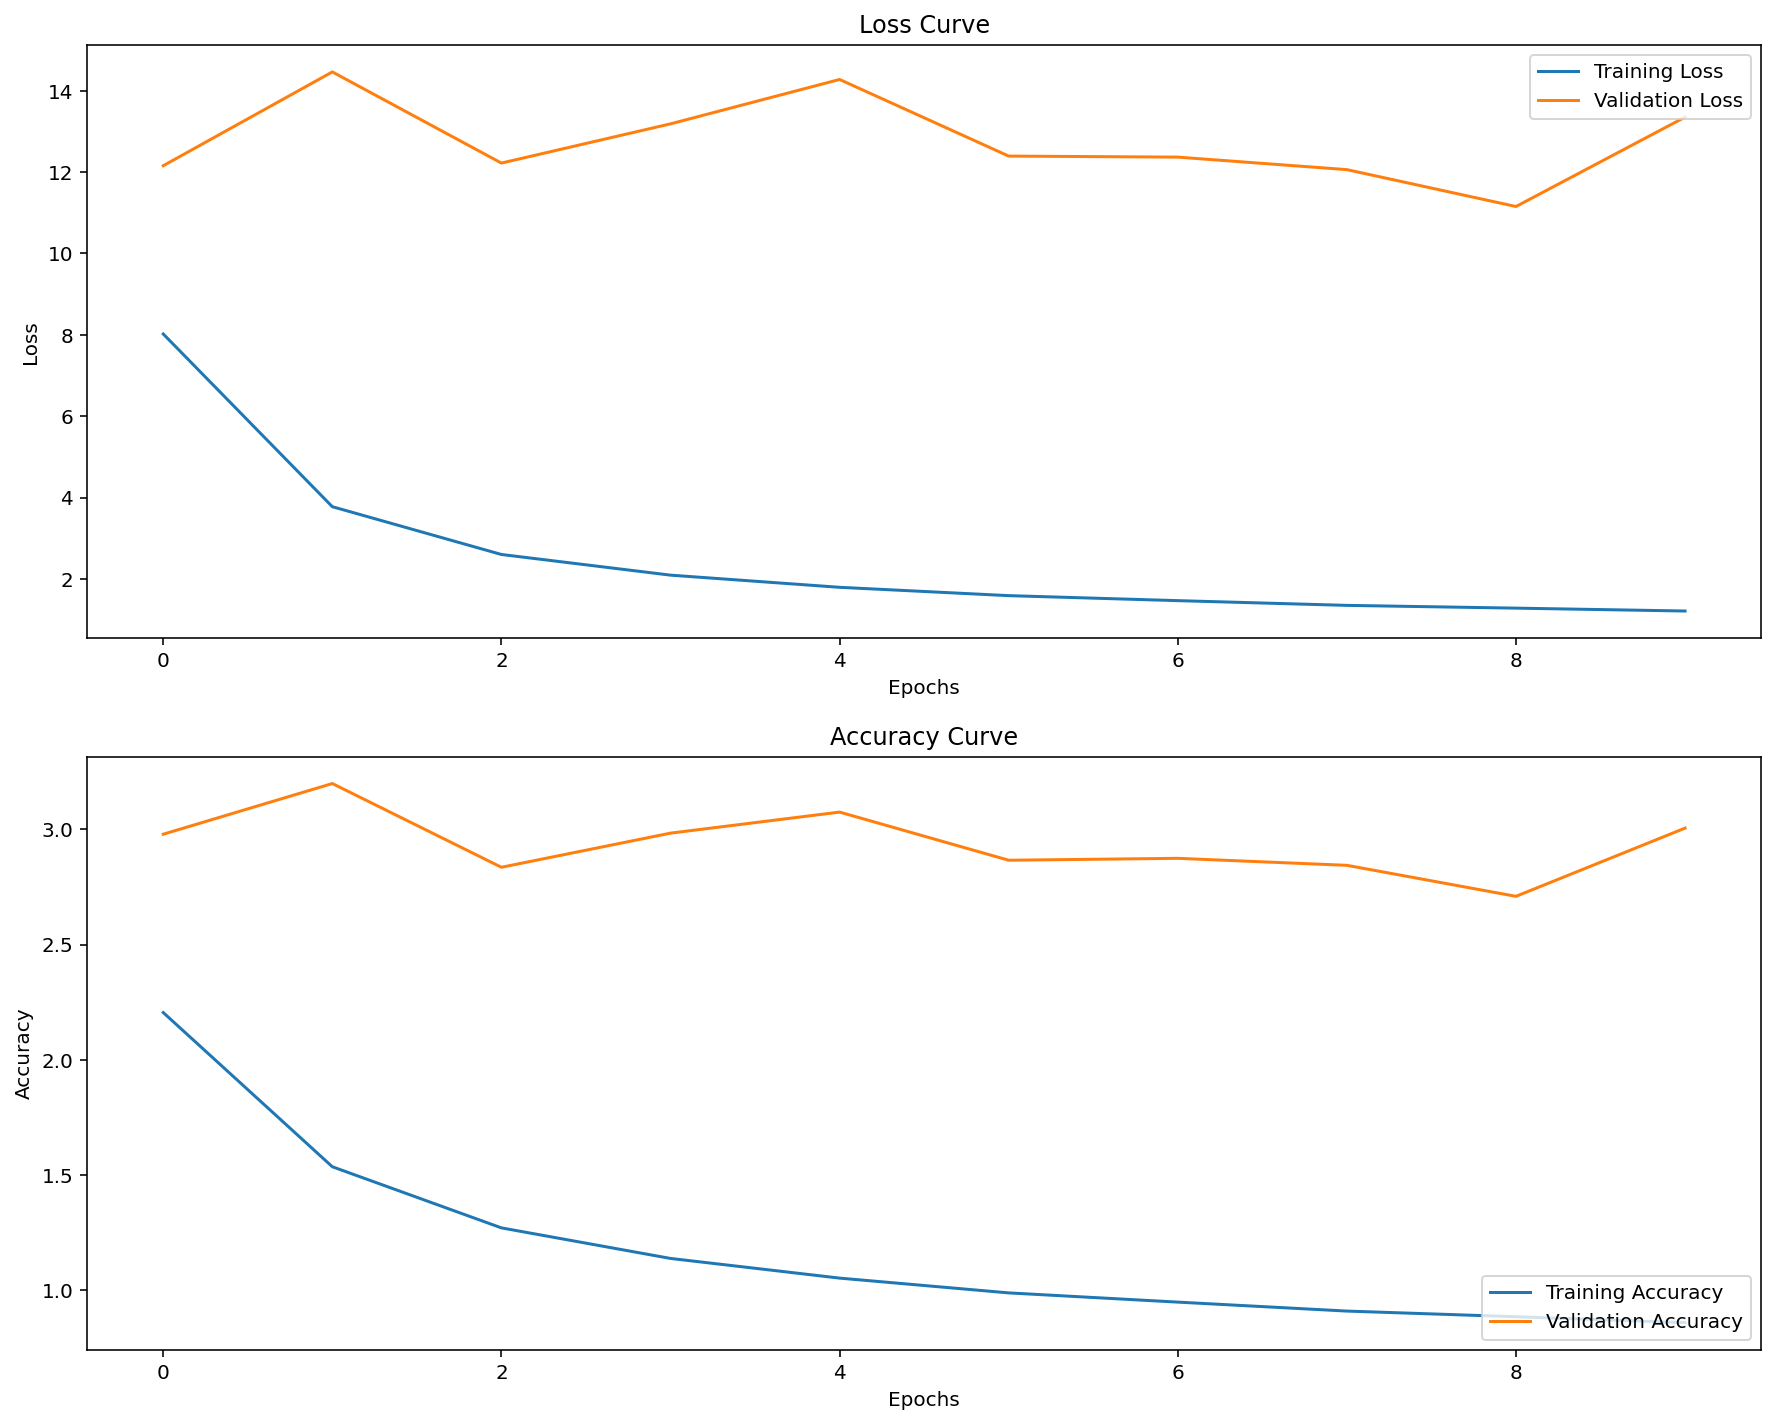

In [ ]:
#@title Plots
import matplotlib.pyplot as plt
import tensorflow as tf
best_model = tf.keras.models.load_model('/tmp/epp_best_model.keras')
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(test_loss)
print(test_acc)
# Assuming `history` is the variable that stores the training history from model.fit()

# Create subplots for loss and accuracy curves
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

# Plot the training and validation loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss Curve')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')

# Plot the training and validation accuracy
axs[1].plot(history.history['mae'], label='Training Accuracy')
axs[1].plot(history.history['val_mae'], label='Validation Accuracy')
axs[1].set_title('Accuracy Curve')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')

# Display the plots
plt.show()

In [219]:
#@title Approach 1 - RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut
import joblib



is_LOSO = True #@param{type: "boolean"}
is_finetune = False #@param{type: "boolean"}
is_model_saved = True #@param{type: "boolean"}
saved_model_path = '/x20/users/ca/cadyxu/eit/pinch-force-v2-models/exp_rf_model.joblib' #@param{type: "string"}


num_estimators = 10 #@param
def pred(X_train, X_test, y_train, y_test):
  model = RandomForestRegressor(
      n_estimators=num_estimators,
      random_state=42)
  if len(X_train.shape) > 2:
    X_train = X_train.reshape(X_train.shape[0], window_size * 12)
    X_test = X_test.reshape(X_test.shape[0], window_size * 12)

  model.fit(X_train, y_train)
  if is_model_saved:
    with open(saved_model_path, 'wb') as f:
      joblib.dump(model, f)


  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  return (mse, r2)


if not is_LOSO:
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
  mse, r2 = pred(X_train, X_test, y_train, y_test)
  print(mse)
  print(r2)
else:
  logo = LeaveOneGroupOut()
  logo_session = LeaveOneGroupOut()
  LOSO_result = {}
  LOSO_result_session = {}
  print(users)
  for train_index, test_index in logo.split(data, labels, groups=users):
    current_group = users[test_index[0]]
    print(users[test_index])
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    if not is_finetune:
      LOSO_result[current_group] = pred(X_train, X_test, y_train, y_test)
      print(LOSO_result[current_group])
    if is_finetune:
      for fs_train_index, fs_test_index in logo_session.split(X_test, y_test, groups=sessions[test_index]):
        current_session = sessions[fs_test_index[0]]
        print(sessions[fs_test_index])
        fs_X_train, fs_X_test = X_test[fs_train_index], X_test[fs_test_index]
        fs_y_train, fs_y_test = y_test[fs_train_index], y_test[fs_test_index]
        LOSO_result_session[current_group] = pred(fs_X_test, X_test, fs_y_test, y_test)
        print(LOSO_result_session[current_group])
        break


  print(LOSO_result)
  print(LOSO_result_session)



['p25' 'p25' 'p25' ... 'p41' 'p41' 'p41']
['p25' 'p25' 'p25' ... 'p25' 'p25' 'p25']
(0.13830544089265395, -0.08843402603785133)
['p27' 'p27' 'p27' ... 'p27' 'p27' 'p27']
(0.060193843907821204, 0.5038774048144399)
['p28' 'p28' 'p28' ... 'p28' 'p28' 'p28']
(0.1311980117101951, -0.13256812627297543)
['p29' 'p29' 'p29' ... 'p29' 'p29' 'p29']
(0.5430971098795403, -2.8922930234077127)
['p30' 'p30' 'p30' ... 'p30' 'p30' 'p30']
(0.2490217303557005, -0.7175517007845171)
['p31' 'p31' 'p31' ... 'p31' 'p31' 'p31']


KeyboardInterrupt: 

In [ ]:
#@title Approach 1 - RandomForest Evaluation

saved_model_path = '/x20/users/ca/cadyxu/eit/pinch-force-v2-models/best_rf_model.joblib' #@param{type: "string"}
import joblib
from sklearn.metrics import mean_squared_error

with open(saved_model_path, 'rb') as f:
  loaded_model = joblib.load(f)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

X_test = X_test.reshape(X_test.shape[0], window_size * 12)
y_pred_loaded = loaded_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_loaded)

data_new = data_new.reshape(data_new.shape[0], window_size * 12)
y_pred_loaded_new = loaded_model.predict(data_new)
mse_new = mean_squared_error(labels_new, y_pred_loaded_new)

print(mse)
print(mse_new)

0.017564697318396275
0.024898434757409868


(5297,)


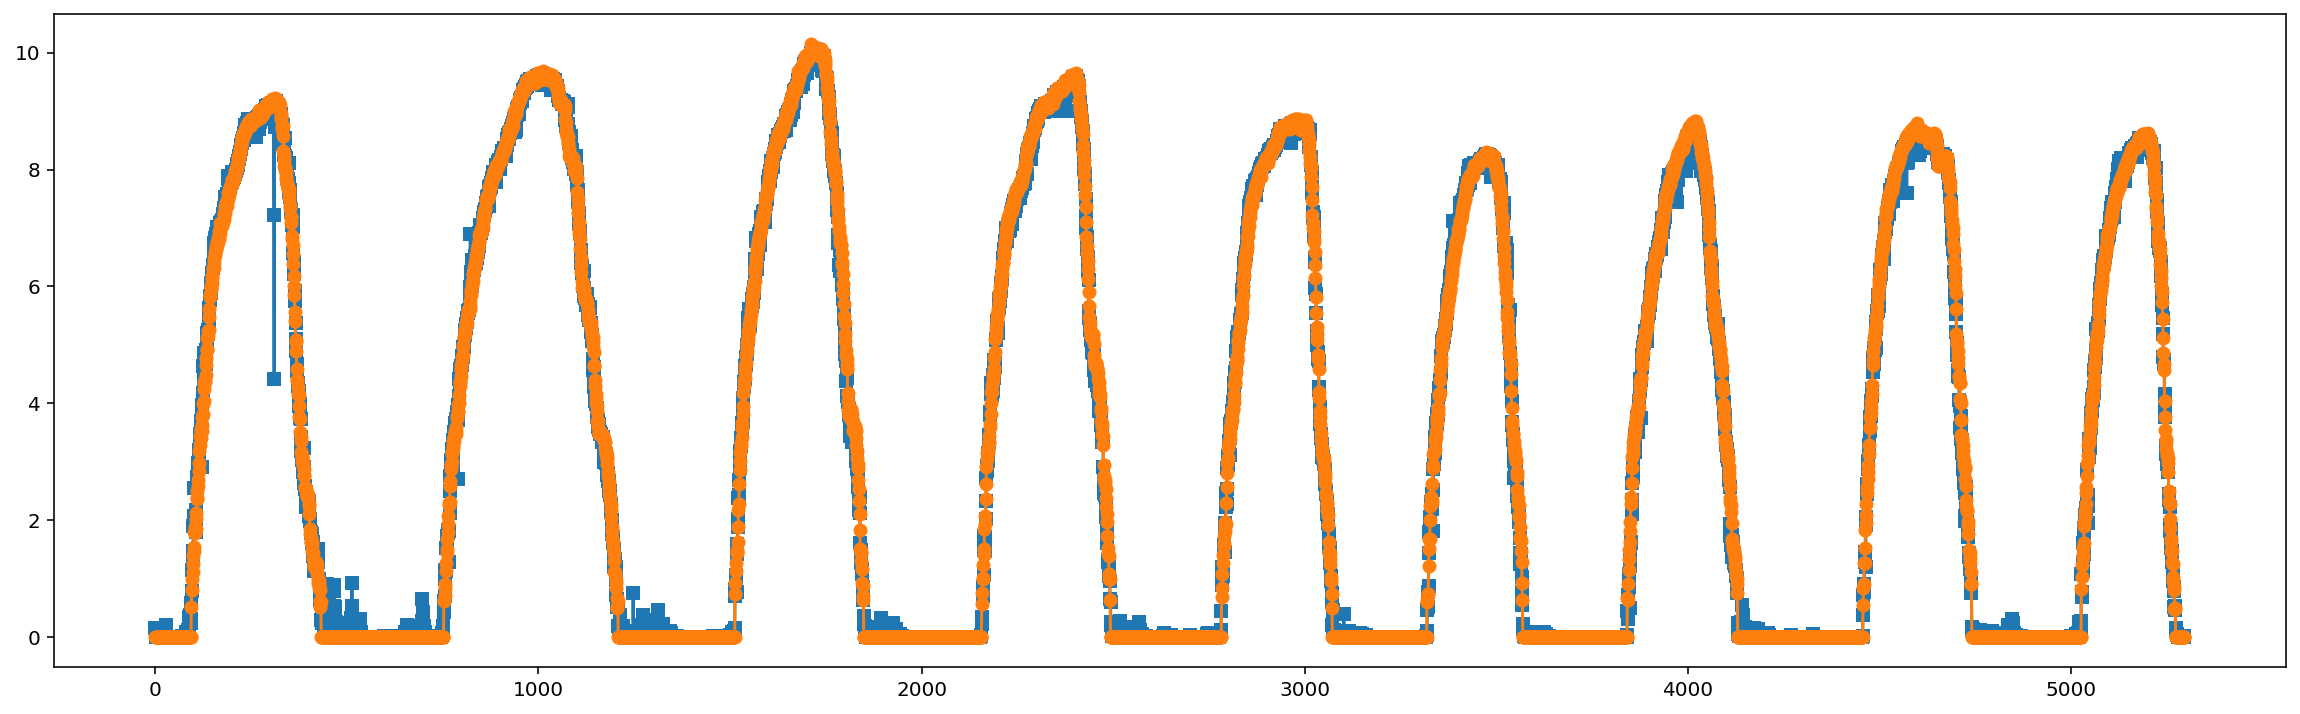

(2, 5297)


In [ ]:
#@title Approach 1 - RandomForest - Visualization

import matplotlib.pyplot as plt
saved_csv_path = '/x20/users/ca/cadyxu/eit/pinch-force-v2-models/p29_result.csv' #@param{type: "string"}


data_to_plot_1 = y_pred_loaded_new
data_to_plot_2 = labels_new
num_samples = len(data_to_plot_1)
plt.figure(figsize=(20, 6))
x = range(len(data_to_plot_1))
print(data_to_plot_1.shape)
plt.plot(x[:num_samples], data_to_plot_1[:num_samples], marker='s')
plt.plot(x[:num_samples], data_to_plot_2[:num_samples], marker='o')
plt.show()

np_to_csv = np.vstack([data_to_plot_1, data_to_plot_2])
print(np_to_csv.shape)

with open(saved_csv_path, 'wb') as f:
  np.savetxt(f, np_to_csv, delimiter=",")



# print(y_pred_loaded[:10])
# print(y_test[:10])

In [ ]:
# LOSO_result = {'p24': (24.90697532838613, -2.1707521764685893), 'p25': (25.088540465810784, -1.3534596657668154), 'p26': (10.721591102270521, -0.9132737279275891), 'p27': (26.489628593655457, -0.8016027463905722), 'p28': (22.444215871204605, -0.6584552065639588), 'p29': (25.06006570312082, -0.9221363285487973), 'p30': (26.147049767423365, -0.880818944955466), 'p31': (42.90885222261295, -1.6780911775022016), 'p32': (59.18871376844276, -3.3029442037528387), 'p33': (18.589459724654944, -0.7277160071741955), 'p34': (15.91594533759355, -0.4680131948250663), 'p35': (21.059298312598553, -0.44994203569086144), 'p36': (12.978648195919392, -0.4947250065216089), 'p37': (5.060074266122278, -0.3490838856104239), 'p38': (9.640156720249117, -0.2979091084233212)}

print(LOSO_result)
print(LOSO_result.values())
print( np.mean([i for i, j in LOSO_result.values()]))
print( np.mean([j for i, j in LOSO_result.values()]))

print(LOSO_result_session)
print(LOSO_result_session.values())
print( np.mean([i for i, j in LOSO_result_session.values()]))
print( np.mean([j for i, j in LOSO_result_session.values()]))


{'p25': (22.83647851983161, -1.0941384244533907), 'p27': (8.76490560999222, 0.40388450661032693), 'p28': (14.953238095109574, -0.08076244182043513), 'p29': (20.387006365443867, -0.5316691840037371), 'p30': (27.6702192235582, -0.9868276433815759), 'p31': (27.586087622745396, -0.7337630183790573), 'p32': (83.14850344946883, -4.877102862423831), 'p33': (13.841522004195904, -0.27862973712859507), 'p34': (14.259067146064767, -0.3151904126534666), 'p35': (29.612407846796106, -1.0388274232957375), 'p37': (3.968778436724891, -0.042595655453704584), 'p38': (35.292008450919425, -3.7643967402019722), 'p39': (32.8025557795587, -2.6231416075749756), 'p40': (18.596518747615747, 0.11061687003761289), 'p41': (53.13502265416268, -1.2866891308619772)}
dict_values([(22.83647851983161, -1.0941384244533907), (8.76490560999222, 0.40388450661032693), (14.953238095109574, -0.08076244182043513), (20.387006365443867, -0.5316691840037371), (27.6702192235582, -0.9868276433815759), (27.586087622745396, -0.73376301

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_deepmind_gpu_py3_cadyxu.kernel.cadyxu.3453212829436.14b334fb3717c109/mount/server/dm_notebook3.par/google3/third_party/py/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide


In [ ]:
#@title Approach 1 - RandomForestClassifier - 3 class

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


is_finegrained = False #@param{type: "boolean"}
is_LOSO = True #@param{type: "boolean"}

low_pressure_boundary = 4 #@param
high_pressure_boundary = 7 #@param
classifier = RandomForestClassifier(n_estimators=10, random_state=42)

target_names = [str(i) for i in range(10)] if is_finegrained else ['light', 'median', 'hard']

def classify_pressure(pressure):
  if is_finegrained:
    if pressure >= 9.5:
      return 9
    else:
      return int(np.round(pressure))
  else:
    if pressure == 0:
      return 0
    elif pressure < low_pressure_boundary:
      return 1
    elif pressure < high_pressure_boundary:
      return 2
    else:
      return 3

def pred(X_train, X_test, y_train, y_test):
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  # class_report = classification_report(y_test, y_pred, target_names=target_names)
  print(f"Accuracy: {accuracy * 100}")
  # print(f"Classification Report:\n{class_report}")
  # Plot confusion matrix as a heatmap
  # conf_matrix = confusion_matrix(y_test, y_pred)
  # plt.figure(figsize=(10, 7))
  # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
  # plt.xlabel('Predicted')
  # plt.ylabel('Actual')
  # plt.title('Confusion Matrix')
  # plt.show()
  return accuracy

labels_c = np.array([classify_pressure(y_i) for y_i in labels])
if not is_LOSO:
  X_train, X_test, y_train, y_test = train_test_split(data, labels_c, test_size=0.2, random_state=42)
  accuracy = pred(X_train, X_test, y_train, y_test)
  print(accuracy)
else:
  logo = LeaveOneGroupOut()
  logo_session = LeaveOneGroupOut()
  LOSO_result = {}
  for train_index, test_index in logo.split(data, labels_c, groups=users):
    current_group = users[test_index[0]]
    print(users[test_index])
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels_c[train_index], labels_c[test_index]
    LOSO_result[current_group] = pred(X_train, X_test, y_train, y_test)

    for fs_train_index, fs_test_index in logo_session.split(X_test, y_test, groups=sessions[test_index]):
      current_session = sessions[fs_test_index[0]]
      print(sessions[fs_test_index])
      fs_X_train, fs_X_test = X_test[fs_train_index], X_test[fs_test_index]
      fs_y_train, fs_y_test = y_test[fs_train_index], y_test[fs_test_index]
      LOSO_result[current_group] = pred(fs_X_test, X_test, fs_y_test, y_test)
      break

  print(LOSO_result)
print(np.mean(list(LOSO_result.values())))


['p24' 'p24' 'p24' ... 'p24' 'p24' 'p24']
Accuracy: 31.58879273130923
['1' '1' '1' ... '1' '1' '1']
Accuracy: 57.24710670750509
['p25' 'p25' 'p25' ... 'p25' 'p25' 'p25']
Accuracy: 43.89288047028086
['1' '1' '1' ... '1' '1' '1']
Accuracy: 51.324997667257634
['p26' 'p26' 'p26' ... 'p26' 'p26' 'p26']
Accuracy: 40.183711753671005
['1' '1' '1' ... '1' '1' '1']
Accuracy: 57.88213985380685
['p27' 'p27' 'p27' ... 'p27' 'p27' 'p27']
Accuracy: 12.127236580516898
['1' '1' '1' ... '1' '1' '1']
Accuracy: 88.5296914167171
['p28' 'p28' 'p28' ... 'p28' 'p28' 'p28']
Accuracy: 53.80035721373289
['1' '1' '1' ... '1' '1' '1']
Accuracy: 66.31772177019249
['p29' 'p29' 'p29' ... 'p29' 'p29' 'p29']
Accuracy: 53.39649911674964
['1' '1' '1' ... '1' '1' '1']
Accuracy: 88.43209678282747
['p30' 'p30' 'p30' ... 'p30' 'p30' 'p30']
Accuracy: 43.58525821969547
['1' '1' '1' ... '1' '1' '1']
Accuracy: 52.93603148729774
['p31' 'p31' 'p31' ... 'p31' 'p31' 'p31']
Accuracy: 28.381534039877852
['1' '1' '1' ... '1' '1' '1']
A

In [ ]:
print(LOSO_result.values())
print(np.mean(list(LOSO_result.values())))

dict_values([(3.353999376296997, 0.5076717138290405), (1.2844772338867188, 0.7334468960762024), (2.530693531036377, 0.6102748513221741), (1.1492737531661987, 0.7537103295326233), (2.2010581493377686, 0.6589004993438721), (1.7393109798431396, 0.6807383298873901), (2.7376911640167236, 0.6069437265396118), (1.4029844999313354, 0.6809940338134766), (1.4247864484786987, 0.7117848992347717), (2.3078644275665283, 0.6181976199150085), (1.4506057500839233, 0.7286573648452759), (1.832534909248352, 0.6841179728507996), (1.3098976612091064, 0.743127703666687), (1.4241036176681519, 0.76372230052948), (1.1943401098251343, 0.6863076686859131)])
1.2504072507222495


In [ ]:
# Evaluate the classifier
accuracy = accuracy_score(y_test_classification, y_pred)
conf_matrix = confusion_matrix(y_test_classification, y_pred)
class_report = classification_report(y_test_classification, y_pred, target_names=target_names)

# Print accuracy and classification report
print(f"Accuracy: {accuracy * 100}")
print(f"Classification Report:\n{class_report}")

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=["light", "median", "hard"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#@title Modeling

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint


model = Sequential()
# model.add(Reshape((12, 1)))
# model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(12,)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Define the path to save the best model
checkpoint_filepath = '/tmp/best_model.keras'

# Create a ModelCheckpoint callback to save the model with the lowest validation loss
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',  # You can also use 'val_accuracy' to monitor accuracy instead
    verbose=1,
    save_best_only=True,
    mode='min'  # 'min' for minimizing loss, 'max' for maximizing accuracy
)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

In [ ]:
import tensorflow as tf
best_model = tf.keras.models.load_model('/tmp/best_model.keras')

223/223 [==============================] - 0s 1ms/step


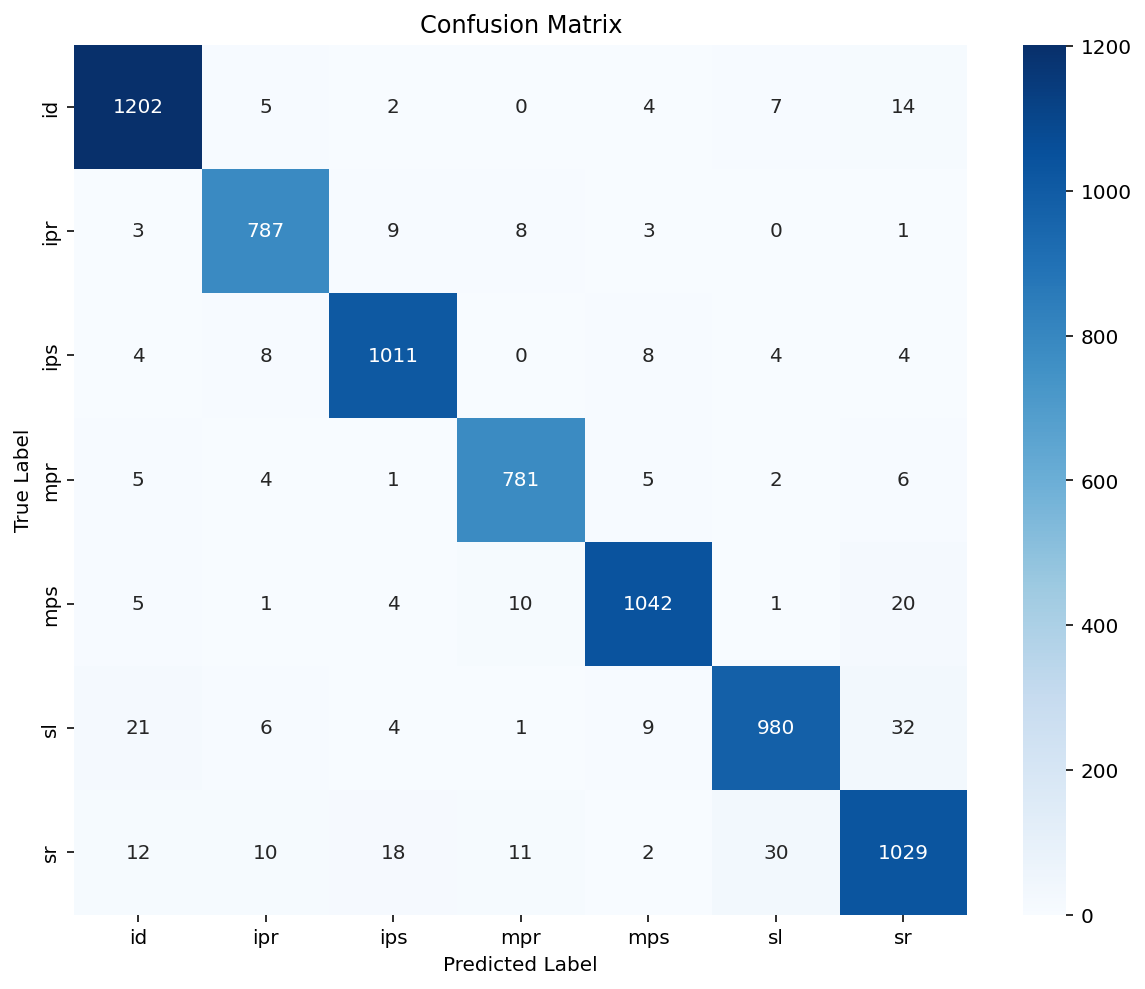

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Sample training and evaluation dataset setup
# This assumes you have your X_train, X_test, y_train, and y_test data ready

# Convert y_test from one-hot encoding to single class labels (for confusion matrix)
y_test_labels = np.argmax(y_test, axis=1)

# Make predictions using the trained model
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

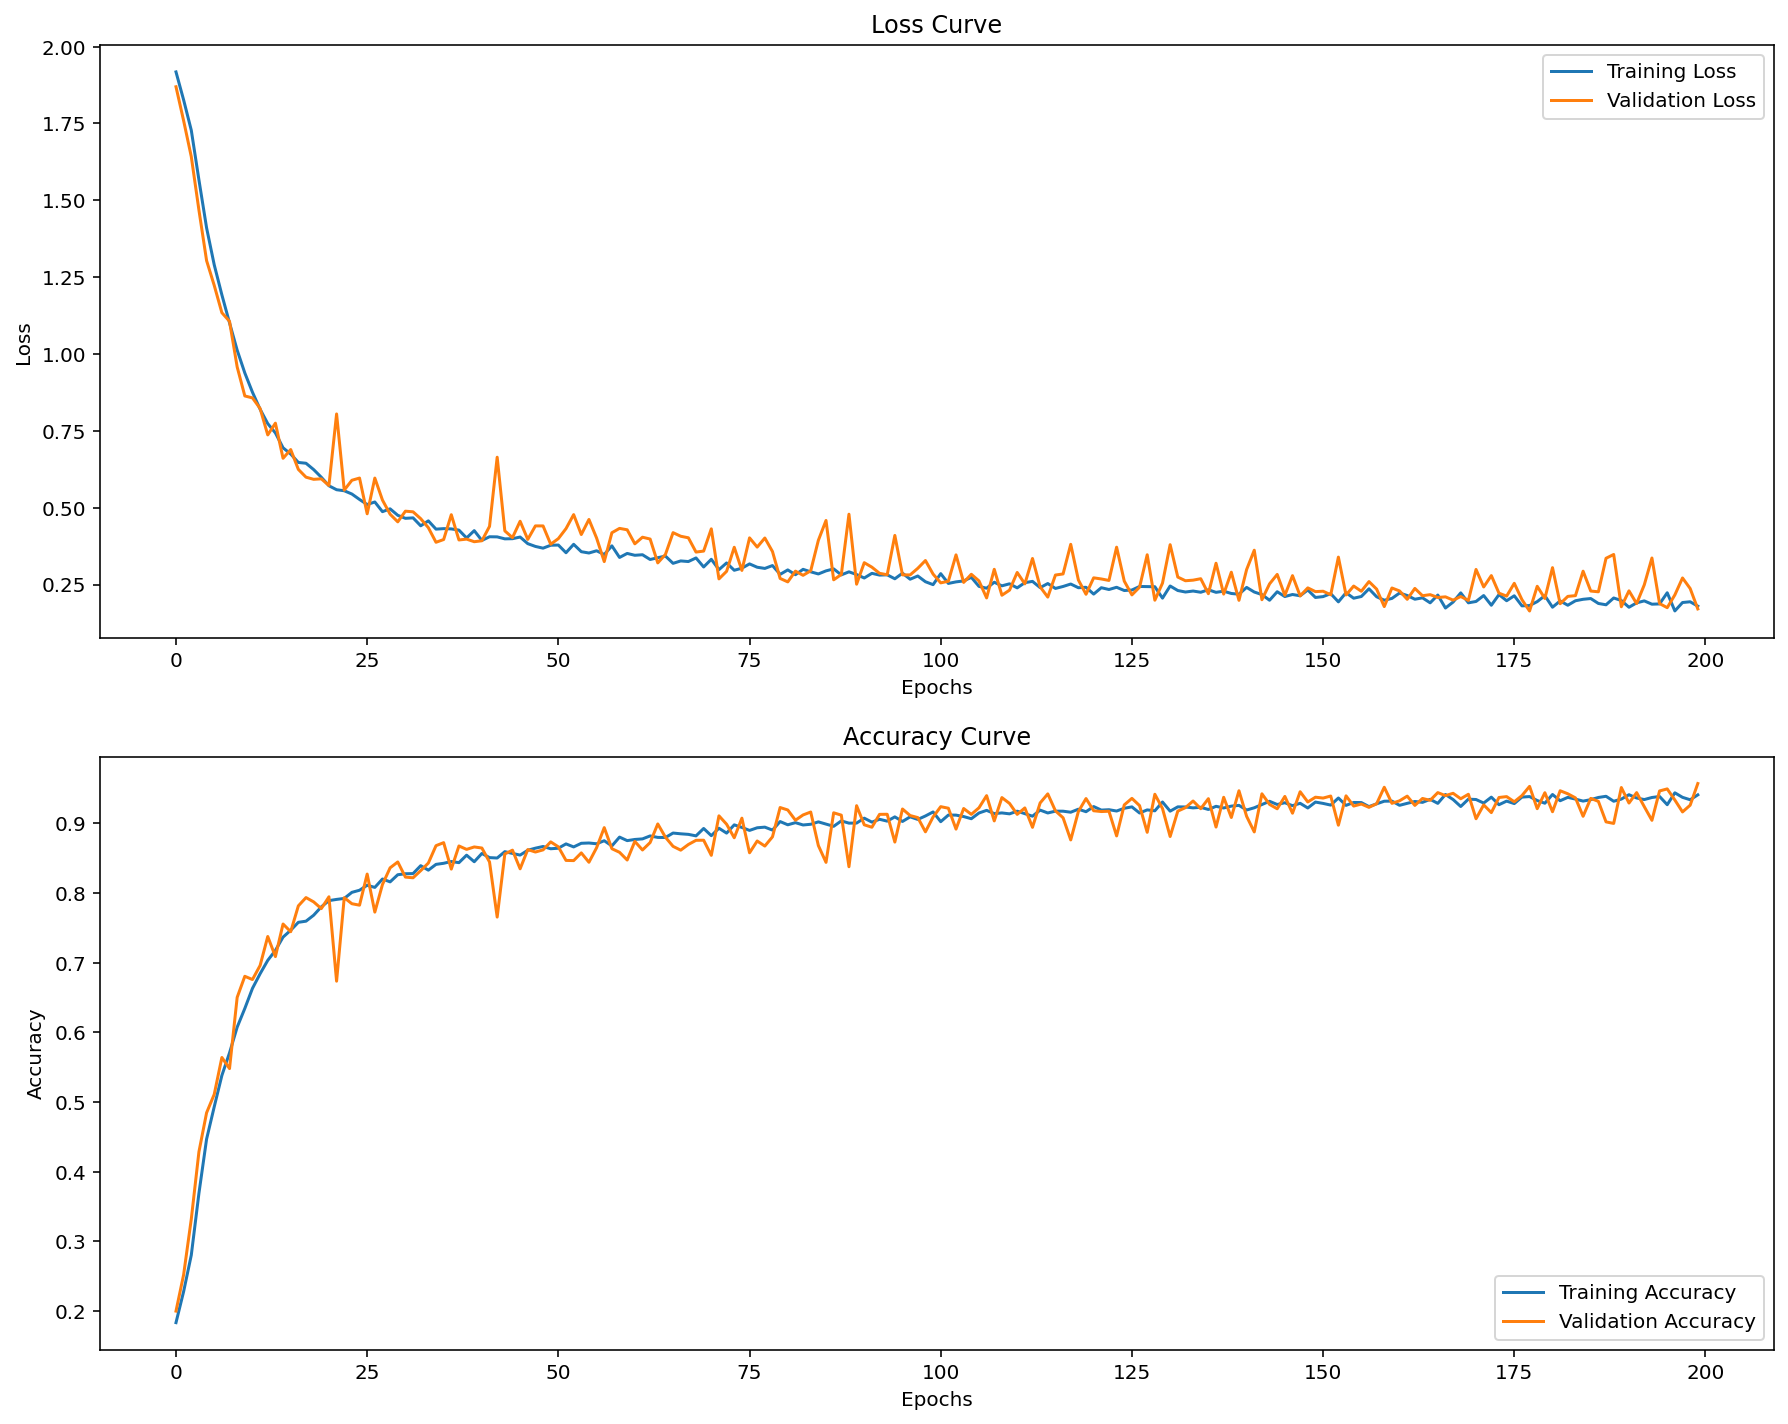

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable that stores the training history from model.fit()

# Create subplots for loss and accuracy curves
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

# Plot the training and validation loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss Curve')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')

# Plot the training and validation accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy Curve')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')

# Display the plots
plt.show()

In [ ]:
# with gfile.Open('/x20/users/ca/cadyxu/eit/microgesture/best_model.keras', 'wb') as f:
#   best_model.save(f)
shutil.copy('/tmp/best_model.keras', '/x20/users/ca/cadyxu/eit/microgesture/best_model.keras', overwrite=True)

In [ ]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Assume data, labels, and users (user IDs) are available from earlier preprocessing
# data: The input data (X)
# labels: The target labels (y)
# users: User or participant IDs corresponding to each data point

# Convert labels to one-hot encoding
labels_one_hot = to_categorical(indexed_labels, num_classes=len(label_set))

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()

# Prepare to store accuracy from each fold
fold_accuracies = []

LOSO_result = {}

# Loop over each fold in LOSO
for train_index, test_index in logo.split(normalized_data, labels_one_hot, groups=sessions):
    # Split data into training and testing sets for the current fold
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels_one_hot[train_index], labels_one_hot[test_index]

    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(60,
    12)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(label_set), activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



    # Define the path to save the best model
    checkpoint_filepath = f'/tmp/{users[test_index][0]}_best_model.keras'

    # Create a ModelCheckpoint callback to save the model with the lowest validation loss
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',  # You can also use 'val_accuracy' to monitor accuracy instead
        verbose=0,
        save_best_only=True,
        mode='max'  # 'min' for minimizing loss, 'max' for maximizing accuracy
    )

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

    # Evaluate the model
    cur_best_model = tf.keras.models.load_model(checkpoint_filepath)
    test_loss, test_acc = cur_best_model.evaluate(X_test, y_test)
    shutil.copy(checkpoint_filepath, f'/x20/users/ca/cadyxu/eit/microgesture/{users[test_index][0]}_best_model.keras', overwrite=True)

    # Save the test accuracy for this fold
    fold_accuracies.append(test_acc)
    print(f"LOSO user: {users[test_index]}")
    print(f"Fold Accuracy: {test_acc} loss: {test_loss}")
    LOSO_result[users[test_index][0]] = (test_acc, test_loss)

# Calculate the average accuracy across all folds
avg_accuracy = np.mean(fold_accuracies)
print(f"Average LOSO Accuracy: {avg_accuracy}")